 # Fisher Forecasting for CMB with LCDM

In [884]:
#Initialization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import camb
from camb import model, initialpower
from operator import add

## Noise covariance

Following 1402.4108, we estimate the noise covariance as

In [885]:
#Experimental parameters
NET = 350 #Noise-Equivalent Temperature, in μK
f_sky = 0.75 #Fraction of sky coverage, in μK-arcmin. Example value
N_det = 1e5 #Number of detectors. Example value
Y_yield = 0.25
observing_period = 5*365*24*3600 #Observing period, in seconds
beam_size = 1*2*np.pi/360 #1' beam, in raidans

sensitivity_s = NET*np.sqrt(f_sky) / np.sqrt(N_det * Y_yield * observing_period)

In [886]:
#Noise covariance matrix. Assuming gaussian noise, the inverse weight is
def gaussian_noise_temp(l):
    beam_FWHM = beam_size / np.sqrt(8*np.log(2))
    return sensitivity_s**2 * np.exp(l*(l+1) * beam_FWHM**2 / (8*np.log(2)))

def gaussian_noise_pol(l):
    beam_FWHM = beam_size / np.sqrt(8*np.log(2))
    return 2*sensitivity_s**2 * np.exp(l*(l+1) * beam_FWHM**2 / (8*np.log(2)))

## Fisher Matrix Calculation

In [887]:
# Set up a fiducial set of cosmological parameters for CAMB
lmax = 2500
params = camb.CAMBparams()
params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, tau=0.06, mnu=0.06, omk=0)
params.InitPower.set_params(As=2e-9, ns=0.965, r=0)
params.set_for_lmax(lmax, lens_potential_accuracy=0)

# List of cosmological parameters that we will take derivatives with respect to
cosmo_params = {
    'H0': ('set_cosmology', 'H0'),
    'ombh2': ('set_cosmology', 'ombh2'),
    'omch2': ('set_cosmology', 'omch2'),
    'tau': ('Reion', 'optical_depth'),
    'As': ('InitPower', 'set_params', 'As'),
    'ns': ('InitPower', 'set_params', 'ns')
}

# Fractional steps for numerical derivatives
fractional_steps = {
    'H0': 0.01,      # 1% step
    'ombh2': 0.01,   # 1% step
    'omch2': 0.01,   # 1% step
    'tau': 0.1,      # 10% step
    'As': 0.01,      # 1% step
    'ns': 0.01,      # 1% step
    'r': 0.1         # 10% step (if r=0, use an absolute step instead)
}

In [888]:
#Get the value of a parameter that we input as the CMB value
def CMB_value(param):
    if param == 'tau':
        original_value = params.Reion.optical_depth
    elif param == 'As':
        original_value = params.InitPower.As
    elif param == 'ns':
        original_value = params.InitPower.ns
    else:
        original_value = getattr(params, param)
        
    return original_value

In [889]:
# Function to compute power spectra given CAMB params
def compute_spectra(params):
    # Get the results
    camb_results = camb.get_results(params)
    # Get the power spectra
    return camb_results.get_cmb_power_spectra(params, CMB_unit='muK')

## Signal Covariance

We first need the covariance matrix $C = C_S + C_N$. \
For the CMB the signal covariance matrix $C_S = \delta_{\ell, \ell^\prime}\; \delta_{m,m^\prime}\; C_\ell$
\
Derivatives of the power spectrum, evaluated at the fiducial values.

In [890]:
# Get the fiducial power spectra
fiducial_spectra = compute_spectra(params)

# Initialize a dictionary to hold the derivatives
derivatives = {param: [] for param in cosmo_params.keys()}

# Compute derivatives with respect to each parameter
for param, attr in cosmo_params.items():

    # Store the original parameter value
    # Ugly solution but whatever - #original_value = getattr(params, param) wasnt working
    if param == 'tau':
        original_value = params.Reion.optical_depth
    elif param == 'As':
        original_value = params.InitPower.As
    elif param == 'ns':
        original_value = params.InitPower.ns
    else:
        original_value = getattr(params, attr[1])
    
    
    # Compute the step for the derivative
    if param == 'r' and original_value == 0:
        step = 0.001  # If r=0, use an absolute step for r
    else:
        step = original_value * fractional_steps[param]
    
    # Modify parameter by +step 
    if param == 'tau':
        setattr(params.Reion, 'optical_depth', original_value + step)
    elif param == 'As':
        setattr(params.InitPower, 'As', original_value + step)
    elif param == 'ns':
        setattr(params.InitPower, 'ns', original_value + step)
    else:
        setattr(params, param, original_value + step)
        
    #Compute spectra
    spectra_plus = compute_spectra(params)
    
    # Modify parameter by -step 
    if param == 'tau':
        setattr(params.Reion, 'optical_depth', original_value - step)
    elif param == 'As':
        setattr(params.InitPower, 'As', original_value - step)
    elif param == 'ns':
        setattr(params.InitPower, 'ns', original_value - step)
    else:
        setattr(params, param, original_value - step)
        
    #Compute spectra
    spectra_minus = compute_spectra(params)
    
    # Compute the numerical derivative
    derivatives[param] = (spectra_plus['total'] - spectra_minus['total']) / (2 * step)
    
    # Reset parameter to original value
    if param == 'tau':
        setattr(params.Reion, 'optical_depth', original_value)
    elif param == 'As':
        setattr(params.InitPower, 'As', original_value)
    elif param == 'ns':
        setattr(params.InitPower, 'ns', original_value)
    else:
        setattr(params, param, original_value)

#Remove the l = 0,1 modes
for key in fiducial_spectra.keys():
    fiducial_spectra[key] = fiducial_spectra[key][2:]
    
for key in derivatives.keys():
    derivatives[key] = derivatives[key][2:]

In [891]:
#Construc the covariance matrix, its inverse and its derivative as defined in Eq 4 of 1402.4108

spectrum_size = (fiducial_spectra['total'].shape)[0] # CAMB computes an additional 50 modes.
covariance_matrix = np.zeros((spectrum_size, 2,2)) #For every mode, construct a 2x2 matrix for T and E modes.
inverse_covariance = np.zeros((spectrum_size, 2,2))
covariance_derivative = {param: np.zeros((spectrum_size, 2,2)) for param in cosmo_params.keys()}

for i in range(spectrum_size): 
    #2x2 matrix of [[TT, ET], [ET, EE]] modes
    signalMat = np.array([[fiducial_spectra['total'][i, 0], fiducial_spectra['total'][i, 3]], 
                          [fiducial_spectra['total'][i, 3], fiducial_spectra['total'][i, 2]] ])
    
    ell = i+2 #Since the 0th entry is the l=2 mode
    noiseMat = np.array([ [gaussian_noise_temp(ell), 0], [0, gaussian_noise_pol(ell)] ])
    
    covariance_matrix[i] = signalMat + noiseMat
    np.linalg.inv(covariance_matrix[i])
    inverse_covariance[i] = np.linalg.inv(covariance_matrix[i]) #Inverse a block diagonal matrix block by block
    
    for param in covariance_derivative.keys(): #Derivates of covariance matrix are taken for each parameter
        covariance_derivative[param][i] = [[derivatives[param][i, 0], derivatives[param][i, 3]], 
                                           [derivatives[param][i, 3], derivatives[param][i, 2]]]

In [892]:
#Testing
inverse_covariance.shape
covariance_matrix.shape
np.mean(np.sign(covariance_matrix).flatten()) #Covariance matrix has many negative values
derivatives.keys()

dict_keys(['H0', 'ombh2', 'omch2', 'tau', 'As', 'ns'])

In [893]:
#Compute the Fisher matrix
fisher_matrix = np.zeros((len(cosmo_params.keys()), len(cosmo_params.keys())))

for i, param1 in enumerate(cosmo_params.keys()):
    for j, param2 in enumerate(cosmo_params.keys()):
        for n in range(spectrum_size): #Iterate over power modes, and trace over the TT, EE matrix
            m1 = inverse_covariance[n]
            m2 = covariance_derivative[param1][n]
            m3 = covariance_derivative[param2][n]
            mat = np.einsum('ij,jk,kl,lm->im', m1, m2, m1, m3)
            fisher_matrix[i, j] += (2*(n+2)+1)/2 * np.trace(mat)
            
fisher_matrix = f_sky * fisher_matrix
fisher_matrix = fisher_matrix + fisher_matrix.T #Quick fix for symmetry
inverse_fisher = np.linalg.inv(fisher_matrix)
inverse_fisher = inverse_fisher + inverse_fisher.T #Quick fix for symmetry

## Marginalized Fisher Matrices

In [894]:
#Takes in an inverse Fisher matrix and outputs a dictionary of 2x2 Fisher-submatrices, where the keys correponds to the unmarginalized parameters
def fisher_marginalized(matrix, keys):
    rows, cols = matrix.shape
    submatrices_dict = {}
    #Take the inverse Fisher matrix
    nParams = (matrix.shape)[0]
    for i in range(rows ):  
        for j in range(i+1, cols): 
            key = (keys[i], keys[j]) #The dictionary key are the unmarginalized parameters
            index1 = i % nParams
            index2 = j % nParams
            submatrix = np.array([[matrix[index1 , index2], matrix[index1, index2]], [matrix[index2, index1], matrix[index2, index2]]])
            # submatrix = matrix[i:i+2, j:j+2] if j < cols - 1 else np.hstack((matrix[i:i+2, j:j+1], matrix[i:i+2, 0:1]))
            # submatrix = inv_mat[i:index1, j:index2]
            # print(i,j,submatrix)
            #print(submatrix)
            submatrices_dict[key] = np.linalg.inv(submatrix) #Uninvert the submatrix, add it to the dictionary
    return submatrices_dict

In [895]:
fisher_marg_dict = fisher_marginalized(inverse_fisher, list(cosmo_params.keys()))

In [896]:
# #Testing
# fisher_marg_keys = list(fisher_marg_dict.keys())
# for key in fisher_marg_keys:
#     print(key, np.linalg.eig(fisher_marg_dict[key])[0])
#     # , np.linalg.eig(positive_diagonals(fisher_marg_dict[key]))[0])

## Plotting

In [897]:
#The maximum width a given parameter would be plotted with. Currently not using this
def max_width(param):
    param_list = list(cosmo_params.keys())
    param_list.remove(param) #All parameters aside from the one we are finding the max width for
    keys = []
    for param2 in param_list:  #Pairs of parameters in the appropriate order
        key_to_sort = (param, param2)
        keys.append(tuple(sorted(key_to_sort, key=lambda k: list(cosmo_params.keys()).index(k))))
    mat_List = [fisher_marg_dict[key] for key in keys]
    evals = np.linalg.eig(mat_List)[0]
    widths = 2 / np.sqrt(np.abs(evals))
    return np.max(widths)

# print(fisher_marg_dict.keys())
# for key in cosmo_params.keys():
#     print(key, max_width(key))

In [898]:
#Formatting for the subplot axes
formatter = ScalarFormatter(useMathText=True)  # useMathText will use 'math mode' for the numbers
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))  # Use scientific notation if exponent is greater than 1 or less than -1

In [899]:
def plot_ellipse_from_matrix(G, ax, key, same_scale = False):
    """ Helper function to add an ellipse to given axes based on matrix G """
    f_signif = 0.197 #95% confidence
    eigenvalues, eigenvectors = np.linalg.eig(G * f_signif)

    width, height = 2 / np.sqrt(np.abs(eigenvalues)) #Quick trick for now
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * (180 / np.pi)

    # x_center = CMB_value(key[0])
    # y_center = CMB_value(key[1])
    x_center = 0
    y_center = 0
    
    ellipse = Ellipse(xy=(x_center, y_center), width=width, height=height, angle=angle, edgecolor='black', facecolor='none', lw=1)
    ax.add_patch(ellipse)
    if same_scale: #Scale by biggest width
        
        ax.set_xlim(x_center - max_width(key[0]), x_center + max_width(key[0])) #Center on CMB values
        ax.set_ylim(y_center - max_width(key[1]), y_center + max_width(key[1]))
    else: #Scale by widths for each subplot
        ax.set_xlim(x_center - width, x_center + width) #Center on CMB values
        ax.set_ylim(y_center - height, y_center + height)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.get_offset_text().set_fontsize(12) 
    ax.xaxis.get_offset_text().set_weight('bold')
    ax.yaxis.get_offset_text().set_fontsize(12)
    ax.yaxis.get_offset_text().set_weight('bold')
    #ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='both', which='both', length=0, labelsize=12)  # No ticks
    ax.grid(True, linestyle='--', alpha=0.5)  # Light grid

In [900]:
plot_label_dict = {
    'H0': r'$\delta \: H_{0}$',      
    'ombh2': r'$\delta \: \Omega_{b} h^2$',   
    'omch2': r'$\delta \: \Omega_{c} h^2$', 
    'tau': r'$\delta \: \tau$',     
    'As': r'$\delta \: A_s$',    
    'ns': r'$\delta \: n_s$',    
    'r': r'$\delta \: r$'   
}

#Label for plot subtitle of model parameters
param_value_string =''
for param in cosmo_params.keys():
    label = plot_label_dict[param].replace('\delta \:','') #Remove the \delta term
    param_value_string = param_value_string + label + ' = ' + f'{CMB_value(param)}' + ', '
 
#Label for experiemental parameters
expm_value_string = '$f_{sky} = 0.75, N_{det} = 10^5$'#r'$f_{\text{sky}} = {:.2f}, \ N_{\text{det}} = {:d}$'.format(f_sky, N_det)
# print(expm_value_string)

plot_label_string = param_value_string + expm_value_string
# print(plot_label_string)

In [901]:
list(fisher_marg_dict.keys())

def reverse_second_keys(key_list):
    # Reverse the order of the second elements for each unique first element
    reversed_list = []
    seen_first_keys = set()
    for first_key, second_key in key_list:
        if first_key not in seen_first_keys:
            # Gather all the second keys for this first key
            second_keys = [pair[1] for pair in key_list if pair[0] == first_key]
            # Reverse the list of second keys
            second_keys.reverse()
            # Create new pairs with the reversed second keys
            reversed_pairs = [(first_key, second_key) for second_key in second_keys]
            reversed_list.extend(reversed_pairs)
            # Add the first key to the set of seen keys
            seen_first_keys.add(first_key)
    return reversed_list

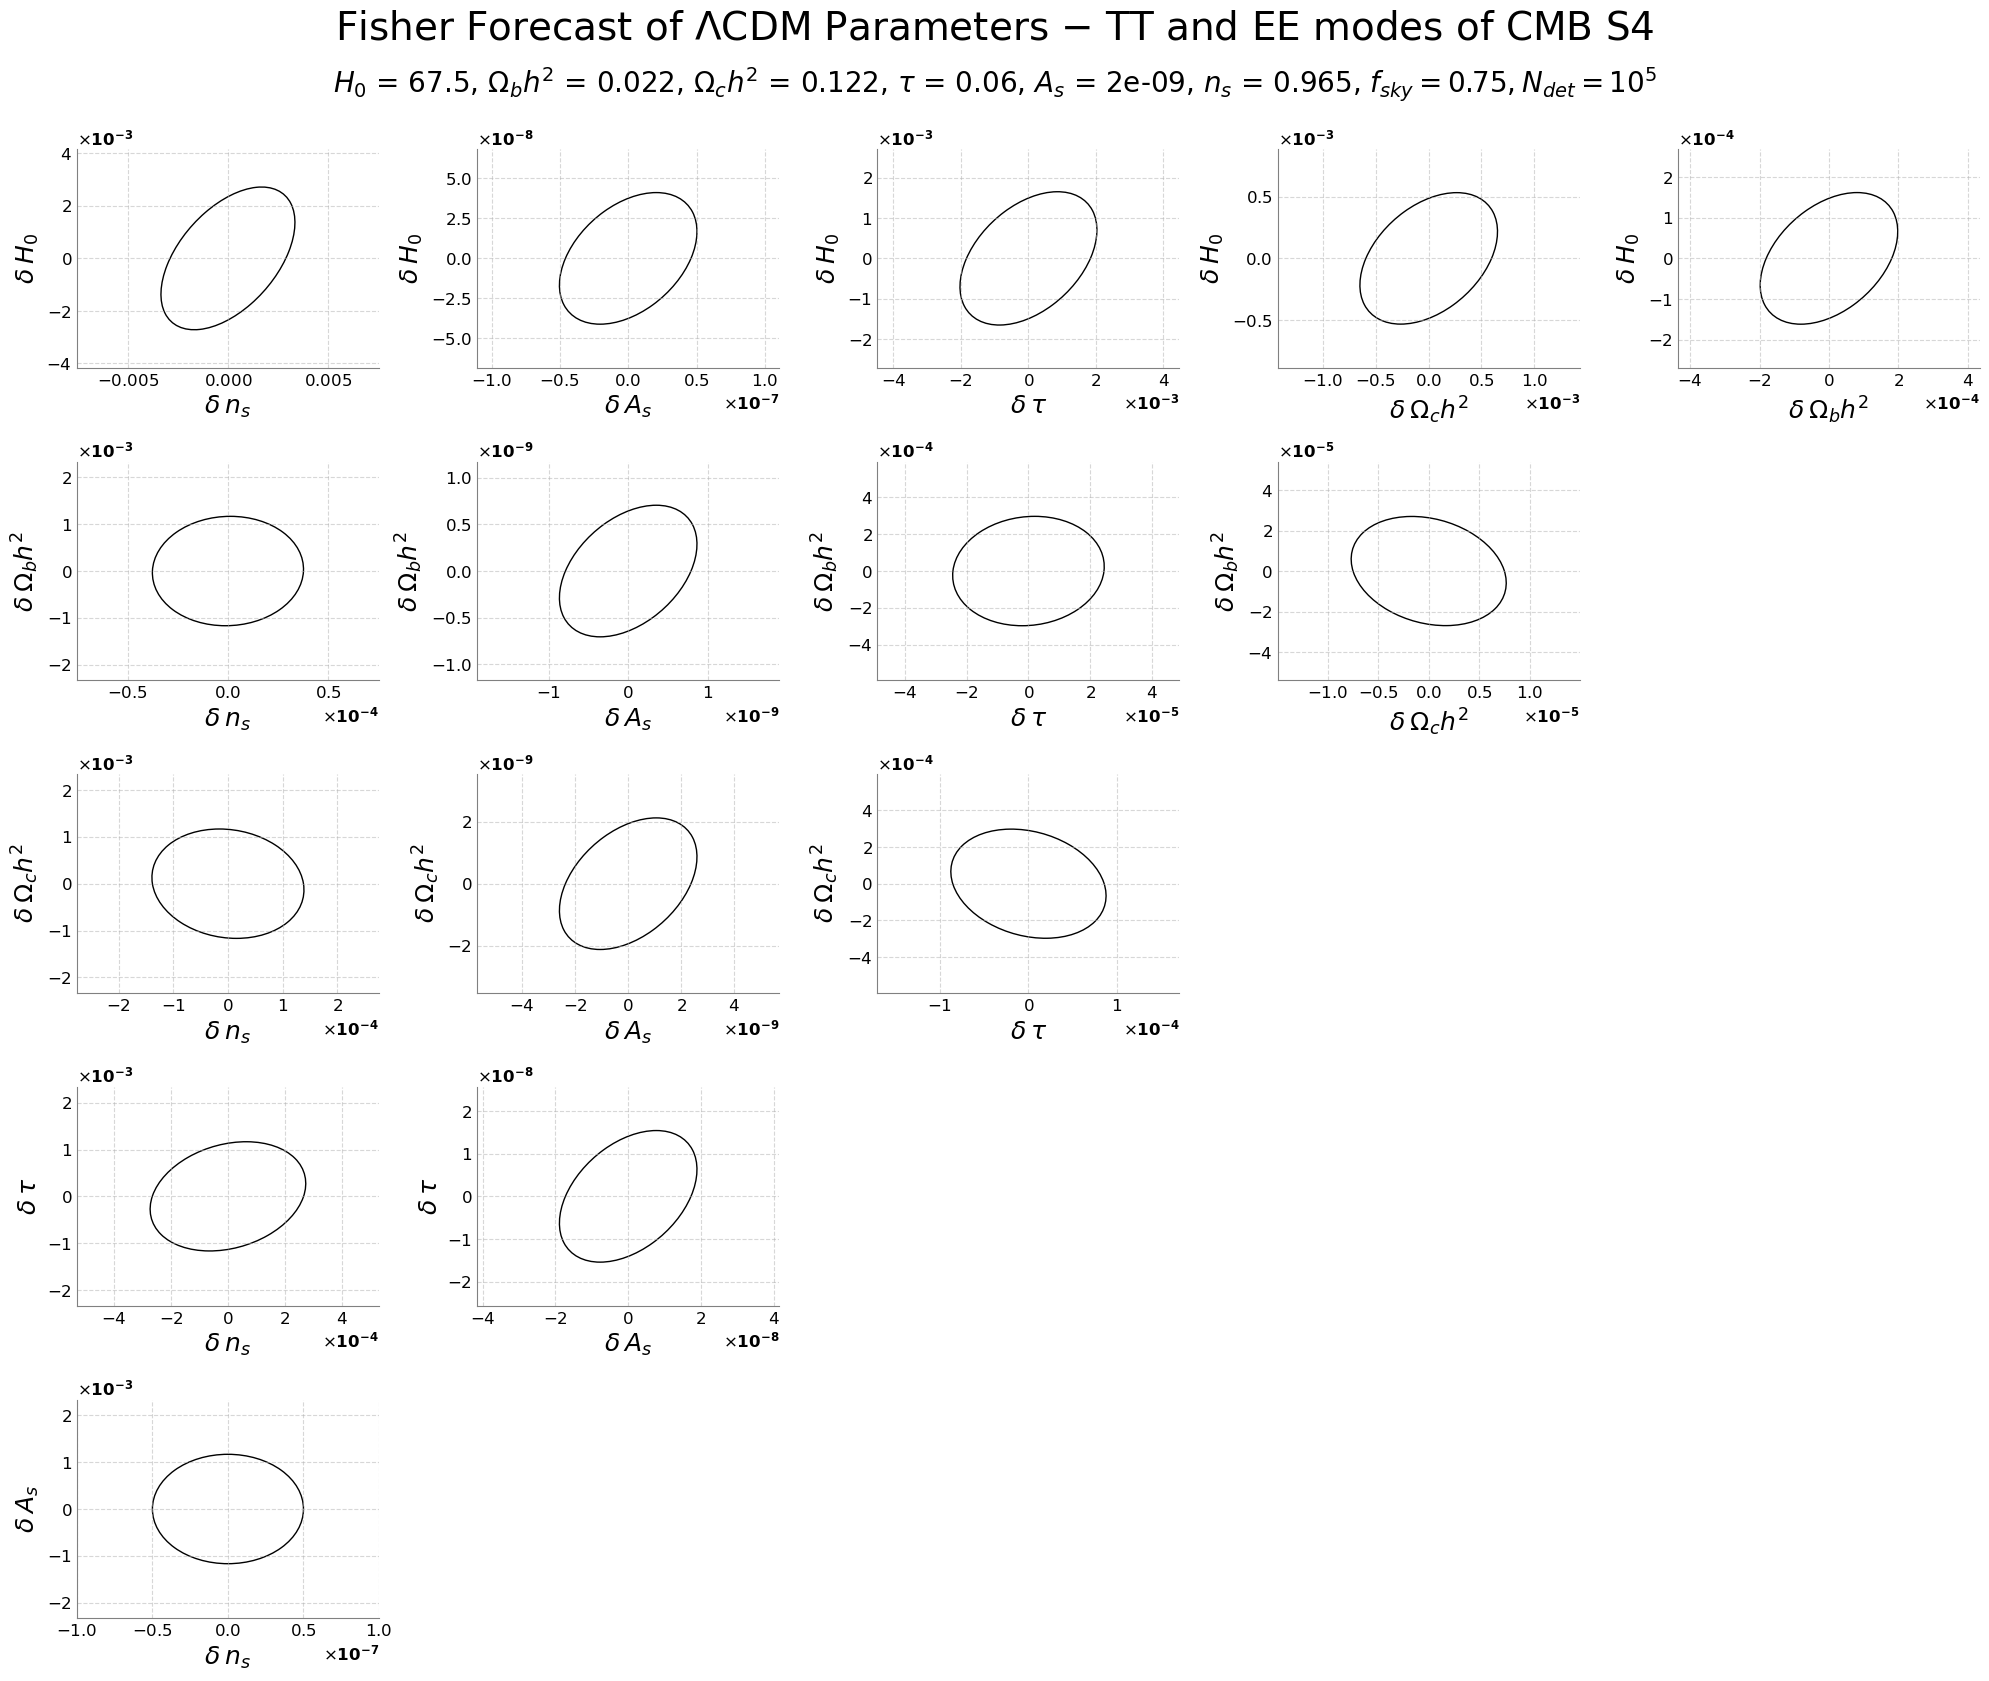

In [902]:
# Grid specification for subplots
rows_layout = [5, 4, 3, 2, 1]

# fig_width = 35  # Width of the entire figure
# fig_height = sum(rows_layout) / max(rows_layout) * fig_width  # Maintain aspect ratio
fig_width = 20  # e.g., 20 inches wide
fig_height = 50  # e.g., 20 inches tall, you can adjust as necessary

fig = plt.figure(figsize=(fig_width, fig_height))
fig.suptitle('Fisher Forecast of $\Lambda$CDM Parameters $-$ TT and EE modes of CMB S4', fontsize = 28)
fig.text(0.5, 0.965, f'{plot_label_string}', ha='center', va='center', fontsize=20)
#fig.subtitle('subtitle Over All Subplots', fontsize = 24)
gs = gridspec.GridSpec(sum(rows_layout), max(rows_layout), figure=fig)

# Keep track of the current position
position_counter = 0
#Keep track of number of plots
plot_counter = 0
keys = reverse_second_keys(list(fisher_marg_dict.keys()))
for row, num_cols in enumerate(rows_layout, start=1):
    for col in range(num_cols):
        ax = fig.add_subplot(gs[position_counter])
        # Retrieve the matrix using the sorted list of dictionary keys
        key = keys[plot_counter]
        plot_ellipse_from_matrix(fisher_marg_dict[key], ax, [key[1], key[0]])
        # Labeling the axes
        ax.set_xlabel(plot_label_dict[key[1]], fontsize=18)
        ax.set_ylabel(plot_label_dict[key[0]], fontsize=18)
        # Increment the position counter
        position_counter += 1
        plot_counter += 1
    # Skip the positions at the end of each row
    position_counter += max(rows_layout) - num_cols

plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig('CMB_Fisher_Forecast_plot.pdf', format = 'pdf')
plt.show()

We use noise covariance matrix (NCVM) for the 70 GHz band of the Low Frequency Instrument (LFI). The noise for the LFI is better understood and the NCVM can be reliably calculated and used for a variety of analyses. The 70 GHz range is the frequency probed by the LFI most relavant to CMB temperature measurements since it is less affected by emmision from galatic sources compared to lower frequencies in the LFI, and certain higher frequencies in the High Frequency Instrument.

In [29]:
noise_cov_pathname = 'covmat_toast_nside64T16_coswin_1sec_70GHz_DX12_full_bin.dat'

In [49]:
noise_covariance_data = np.fromfile(noise_cov_pathname, dtype=np.float64)

In [52]:
NCVM_dim = int(np.sqrt(noise_covariance_data.shape[0]))
if round(NCVM_dim) != NCVM_dim:
    print('Number of noise data points is not a square number!')
else:
    noise_covariance_matrix = noise_covariance_data.reshape((NCVM_dim, NCVM_dim))

In [75]:
#The datafile is block diagonal in the three Strokes Parameters.
#The first 3072 x 3072 block corresponds to intensity, which is what we will consider here.
nPixels = 3072
temperature_NCVM = noise_covariance_matrix[0:nPixels,0:nPixels]

In [70]:
#The data file from the Planck Legacy Archive is a 9216^2 dimensional vector. So the noise covariance matrix is 9216 dimensional. 
#9216 = 3072 x 3, and there are 3072 used in the HEALPix nested pixelisation scheme. 
#The 3 corresponds to 3 spatial coordinates? Maybe its related to mapmaking?
NCVM_dim/3072

3.0

In [107]:
#We must use healpy to convert from a map in HEALPix format to a power sprectrum.
import healpy as hp

#Convert from nested order to ring order. Each column of the correlation matrix is a map, so this is done map by map.
ring_order_NCVM = np.zeros((nPixels, nPixels))
for i in range(nPixels):
    ring_order_NCVM[i] = hp.reorder(temperature_NCVM[i], 'NESTED', 'RING')
#Convert from pixel map to power spectrum

nSide = 16 #resolution of map
#Convert pixel maps to power spectra. Different power spectrum for every map-map correlation.
power_NCVM = np.zeros((nPixels, nPixels, 16*3))
for i in range(nPixels):
    print(i)
    for j in range(i, nPixels):
        power_NCVM[i][j] = hp.anafast(ring_order_NCVM[i], ring_order_NCVM[j])
        power_NCVM[j][i] = power_NCVM[i][j]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [95]:
print(ring_order_NCVM.shape)
power_NCVM.shape

(3072, 3072)


(48,)

In [106]:
ring_order_NCVM.shape

(3072, 3072)

In [103]:
for i in range(2,5):
    print(i)

2
3
4
